# CNN solver

In [240]:
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from torch import nn
import torch.nn.functional as F
from time import time
import contextlib

@contextlib.contextmanager
def timer(msg='timer'):
    tic = time()
    yield
    return print(f"{msg}: {time() - tic:.2f}")

# Neural net solver class

In [242]:
class NeuralNetSolver(nn.Module):
    def __init__(self, T_ini, K, s):
        super(NeuralNetSolver,self).__init__()
        self.nx = T_ini.shape[2]
        self.ny = T_ini.shape[3]
        self.T = nn.Parameter(T_ini[:,:,1:-1,1:-1])
        self.K = K
        self.s = s
        dx = 1./(self.nx-1)
        dy = 1./(self.ny-1)
        self.grad_x = torch.tensor([-1./dx, 1./dx]).reshape((1,1,2,1))
        self.grad_y = torch.tensor([ 1./dy,-1./dy]).reshape((1,1,1,2))
        
        self.avg_x = torch.tensor([.5,.5]).reshape((1,1,2,1))
        self.avg_y = torch.tensor([.5,.5]).reshape((1,1,1,2))
        
    def forward(self):
        T = self.T
        K = self.K
        s = self.s
        
        # Add boundary conditions as padding
        T = torch.cat([torch.zeros((1,1,self.nx-2,1)), T, torch.zeros((1,1,self.nx-2,1))],dim=3)
        T = torch.cat([torch.zeros((1,1,1,self.ny)), T, torch.zeros((1,1,1,self.ny))],dim=2)
        
#         print(self.grad_x)
        dT_dx = F.conv2d(T, self.grad_x)
        dT_dy = F.conv2d(T, self.grad_y)
        
        
        
        K_avg_x = F.conv2d(K, self.avg_x)
        K_avg_y = F.conv2d(K, self.avg_y)
        
        
        
        K_d2T_dx2 = F.conv2d(K_avg_x*dT_dx, self.grad_x)
        K_d2T_dy2 = F.conv2d(K_avg_y*dT_dy, self.grad_y)
        
#         print(K_d2T_dx2.shape)
#         print(K_d2T_dy2.shape)
        
        return K_d2T_dx2[:,:,:,1:-1] + K_d2T_dy2[:,:,1:-1,:] + s[:,:,1:-1,1:-1]

In [243]:
def loss_fn(y_hat):
    # note: expected outcome is 0
    return torch.mean((y_hat)**2)

# Setup

In [244]:
nx = 100
ny = 100
T_ini = torch.zeros((1,1,nx,ny))
K     = torch.ones((1,1,nx,ny))
s     = torch.ones((1,1,nx,ny))
net = NeuralNetSolver(T_ini, K,s)

optimizer = torch.optim.LBFGS(net.parameters())
abs_loss = 1e-10
rel_loss = 1e-100

Stop! relative loss target reached (1.00e-100)
solve: 18.60


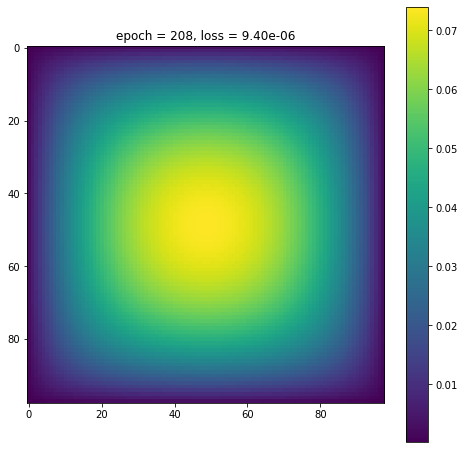

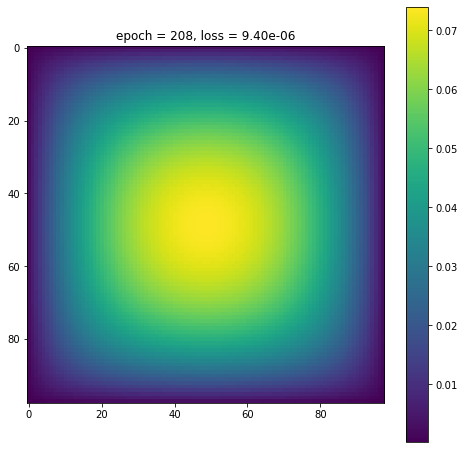

In [245]:


def train(net,loss_fn):
    
    def closure():
        out = net()
        loss = loss_fn(out)
        optimizer.zero_grad()
        loss.backward()
        return loss

      
    last_loss = 1e10
    with timer("solve"):
        for i in range(500):
            loss = optimizer.step(closure)
            with torch.no_grad():
                loss = loss.item()
        #         if (i%10)==0:
        #             plt.title(f"epoch = {i:.0f}, loss = {loss:.2e}")
        #             plt.imshow(net.T.reshape(net.T.shape[2:]))
        #             display(fig)
        #             clear_output(wait = True)
                if loss<abs_loss:
                    print(f"Stop! absolute loss target reached ({abs_loss:.2e})")
                    break
                elif abs(loss-last_loss)<rel_loss:
                    print(f"Stop! relative loss target reached ({rel_loss:.2e})")
                    break

                last_loss = loss     

fig = plt.figure(figsize=[8,8])                
with torch.no_grad():
    plt.title(f"epoch = {i:.0f}, loss = {loss:.2e}")
    plt.imshow(net.T.reshape(net.T.shape[2:]))
    plt.colorbar()
    display(fig)
# clear_output(wait = True)

In [246]:
net.T[0,0,0,:]

tensor([0.0003, 0.0005, 0.0007, 0.0009, 0.0010, 0.0012, 0.0013, 0.0015, 0.0016,
        0.0017, 0.0018, 0.0019, 0.0020, 0.0021, 0.0022, 0.0022, 0.0023, 0.0024,
        0.0025, 0.0025, 0.0026, 0.0027, 0.0027, 0.0028, 0.0028, 0.0029, 0.0029,
        0.0029, 0.0030, 0.0030, 0.0031, 0.0031, 0.0031, 0.0032, 0.0032, 0.0032,
        0.0032, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0034,
        0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0032, 0.0032,
        0.0032, 0.0032, 0.0031, 0.0031, 0.0031, 0.0030, 0.0030, 0.0029, 0.0029,
        0.0029, 0.0028, 0.0028, 0.0027, 0.0027, 0.0026, 0.0025, 0.0025, 0.0024,
        0.0023, 0.0022, 0.0022, 0.0021, 0.0020, 0.0019, 0.0018, 0.0017, 0.0016,
        0.0015, 0.0013, 0.0012, 0.0010, 0.0009, 0.0007, 0.0005, 0.0003],
       grad_fn=<SliceBackward>)

In [247]:
T = net.T

In [187]:
T.shape

torch.Size([1, 1, 20, 20])

In [191]:
B.shape

torch.Size([1, 1, 22, 22])